In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install tensorflow keras

In [20]:
import tensorflow as tf
print (tf.keras.__version__)

3.8.0


**Task 1: Data Understanding and Visualization**

**Load and visualize images from a dataset stored in directories, where each subdirectory represents a class.**

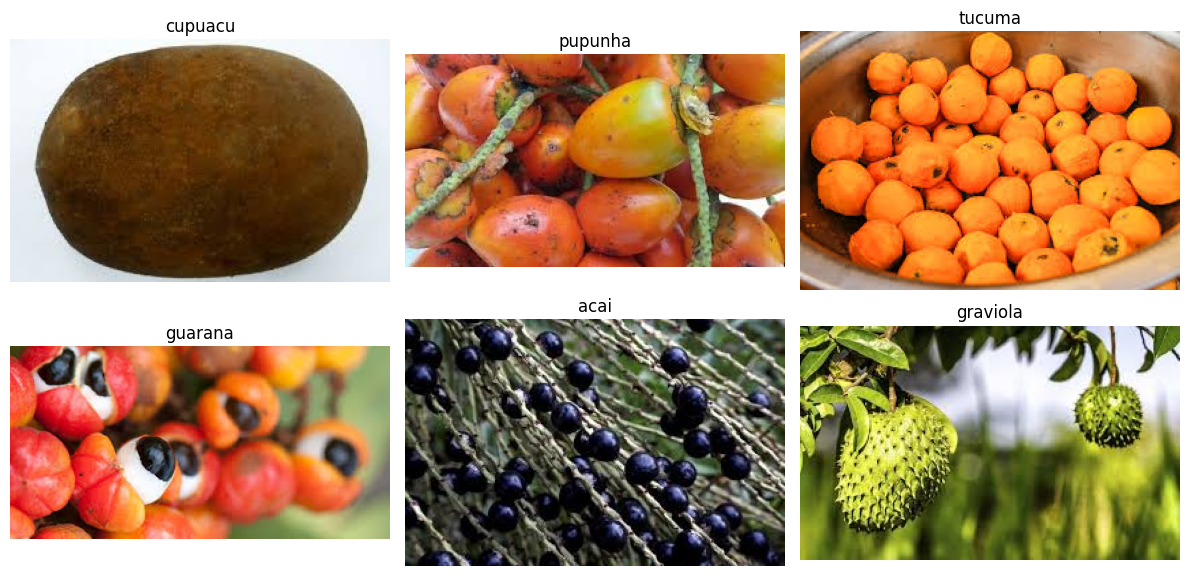

In [21]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the dataset
train_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train"

# Get the list of class directories
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Select one random image from each class
selected_images = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_path)
    random_image = random.choice(image_files)
    selected_images.append((class_name, os.path.join(class_path, random_image)))

# Display the images in a grid format with two rows
fig, axes = plt.subplots(2, len(selected_images) // 2 + len(selected_images) % 2, figsize=(12, 6))

for ax, (class_name, image_path) in zip(axes.flat, selected_images):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")

plt.tight_layout()
plt.show()


**Check for Corrupted Image.**

In [22]:
from PIL import Image
import os

# Define the path to the train folder
train_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train"

# List to store corrupted image paths
corrupted_images = []

# Iterate through each class subdirectory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Check if the image is corrupted
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)  # Remove corrupted image
                print(f"Removed corrupted image: {image_path}")

# Print final message
if not corrupted_images:
    print("No Corrupted Images Found.")
else:
    print(f"Total corrupted images removed: {len(corrupted_images)}")
    print("List of corrupted images:")
    for image_path in corrupted_images:
        print(image_path)

No Corrupted Images Found.


**Task 2: Loading and Preprocessing Image Data in keras**

In [23]:
import tensorflow as tf

# Define image size and batch size
img_height = 128  # Example image height
img_width = 128   # Example image width
batch_size = 32
validation_split = 0.2  # 80% training, 20% validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]

# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply normalization and prefetching for efficiency
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (rescale(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Apply normalization and prefetching for efficiency
val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(buffer_size=AUTOTUNE)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


**Task 3 - Implement a CNN and
Follow the following Structure and Hyper - parameters**

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model
def create_cnn_model(num_classes, input_shape=(128, 128, 3)):
    model = keras.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Convolutional Layer 2
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Flatten layer
        layers.Flatten(),

        # Fully Connected Layers (Hidden Layers)
        layers.Dense(64, activation="relu"),
        layers.Dense(128, activation="relu"),

        # Output Layer (Softmax for Multi-Class Classification)
        layers.Dense(num_classes, activation="softmax")
    ])

    return model

# Example usage
num_classes = 6  # Replace with the actual number of classes in your dataset
model = create_cnn_model(num_classes)
model.summary()  # Print model architecture


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

**Task 4: Compile the Model**

In [25]:
# Compile the model
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

**Task 5: Evaluate the Model**

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the callbacks
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',               # File to save the best model
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save the best model
    mode='min',                    # We want to minimize the validation loss
    verbose=1                       # Print info when saving the model
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',            # Monitor validation loss
    patience=10,                   # Stop after 10 epochs without improvement
    restore_best_weights=True,     # Restore the best weights after stopping
    verbose=1                       # Print info when early stopping is triggered
)

# Train the model with the specified batch size, epochs, and callbacks
history = model.fit(
    train_ds,                      # Training dataset
    validation_data=val_ds,        # Validation dataset
    epochs=250,                    # Number of epochs
    batch_size=16,                 # Batch size
    callbacks=[checkpoint_callback, early_stopping_callback]  # Use callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.1742 - loss: 1.7921
Epoch 1: val_loss improved from inf to 1.75198, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.1793 - loss: 1.7921 - val_accuracy: 0.0000e+00 - val_loss: 1.7520
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.1950 - loss: 1.7781
Epoch 2: val_loss improved from 1.75198 to 1.71197, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 874ms/step - accuracy: 0.1949 - loss: 1.7776 - val_accuracy: 0.1667 - val_loss: 1.7120
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.1787 - loss: 1.7706
Epoch 3: val_loss improved from 1.71197 to 1.69819, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 840ms/step - accuracy: 0.1931 - loss: 1.7693 - val_accuracy: 0.0556 - val_loss: 1.6982
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3120 - loss: 1.7117
Epoch 4: val_loss did not improve from 1.69819
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2931 - loss: 1.7232 - val_accuracy: 0.0000e+00 - val_loss: 1.7375
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.3407 - loss: 1.6939
Epoch 5: val_loss did not improve from 1.69819
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 783ms/step - accuracy: 0.3111 - loss: 1.7069 - val_accuracy: 0.0000e+00 - val_loss: 1.7329
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.3120 - loss: 1.6843
Epoch 6: val_loss improved from 1.69819 to 1.69778, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - accuracy: 0.2931 - loss: 1.6978 - val_accuracy: 0.0556 - val_loss: 1.6978
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2271 - loss: 1.7207
Epoch 7: val_loss improved from 1.69778 to 1.64668, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step - accuracy: 0.2328 - loss: 1.7197 - val_accuracy: 0.1111 - val_loss: 1.6467
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.2854 - loss: 1.6913
Epoch 8: val_loss did not improve from 1.64668
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 832ms/step - accuracy: 0.2766 - loss: 1.6944 - val_accuracy: 0.1111 - val_loss: 1.7109
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.3509 - loss: 1.6830
Epoch 9: val_loss did not improve from 1.64668
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 794ms/step - accuracy: 0.3326 - loss: 1.6856 - val_accuracy: 0.0556 - val_loss: 1.7352
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.4463 - loss: 1.5717
Epoch 10: val_loss did not improve from 1.64668
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 682ms/step - accuracy: 0.4007 - loss: 1.5964 - val_accuracy: 0.2222 - val_loss: 1.7464
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.5012 - loss: 1.6612
Epoch 11: val_loss improved from 1.64668 to 1.52106, sav

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.4939 - loss: 1.6554 - val_accuracy: 0.4444 - val_loss: 1.5211
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.3160 - loss: 1.6827
Epoch 12: val_loss did not improve from 1.52106
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step - accuracy: 0.3411 - loss: 1.6725 - val_accuracy: 0.6111 - val_loss: 1.5241
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.4926 - loss: 1.4776
Epoch 13: val_loss did not improve from 1.52106
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - accuracy: 0.4701 - loss: 1.5151 - val_accuracy: 0.2222 - val_loss: 1.6790
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6056 - loss: 1.4199
Epoch 14: val_loss did not improve from 1.52106
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - accuracy: 0.5583 - loss: 1.4582 - val_accuracy: 0.1111 - val_loss: 1.7454
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5301 - loss: 1.5688
Epoch 15: val_loss improved from 1.52106 to 1.51286,

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step - accuracy: 0.5295 - loss: 1.5598 - val_accuracy: 0.2222 - val_loss: 1.5129
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.3889 - loss: 1.5433
Epoch 16: val_loss improved from 1.51286 to 1.34435, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step - accuracy: 0.3958 - loss: 1.5334 - val_accuracy: 0.6667 - val_loss: 1.3443
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.5241 - loss: 1.4514
Epoch 17: val_loss did not improve from 1.34435
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - accuracy: 0.5111 - loss: 1.4542 - val_accuracy: 0.1111 - val_loss: 1.8255
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.4609 - loss: 1.4524
Epoch 18: val_loss did not improve from 1.34435
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - accuracy: 0.4429 - loss: 1.4557 - val_accuracy: 0.0556 - val_loss: 1.8828
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4875 - loss: 1.4227
Epoch 19: val_loss did not improve from 1.34435
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 0.4906 - loss: 1.4200 - val_accuracy: 0.1667 - val_loss: 1.6514
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4201 - loss: 1.4081
Epoch 20: val_loss did not improve from 1.34435
3/3 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 779ms/step - accuracy: 0.5049 - loss: 1.4484 - val_accuracy: 0.6111 - val_loss: 1.3236
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.6611 - loss: 1.2698
Epoch 23: val_loss did not improve from 1.32359
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 886ms/step - accuracy: 0.6417 - loss: 1.2798 - val_accuracy: 0.4444 - val_loss: 1.3688
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.4465 - loss: 1.2624
Epoch 24: val_loss did not improve from 1.32359
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - accuracy: 0.4495 - loss: 1.2542 - val_accuracy: 0.7222 - val_loss: 1.3312
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6546 - loss: 1.1180
Epoch 25: val_loss improved from 1.32359 to 1.16984, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step - accuracy: 0.6507 - loss: 1.1131 - val_accuracy: 0.5556 - val_loss: 1.1698
Epoch 26/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.6289 - loss: 1.1227
Epoch 26: val_loss did not improve from 1.16984
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - accuracy: 0.6106 - loss: 1.1360 - val_accuracy: 0.0000e+00 - val_loss: 2.9436
Epoch 27/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.3602 - loss: 1.3279
Epoch 27: val_loss did not improve from 1.16984
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step - accuracy: 0.3465 - loss: 1.3766 - val_accuracy: 0.5000 - val_loss: 1.3956
Epoch 28/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5891 - loss: 1.2497
Epoch 28: val_loss did not improve from 1.16984
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.5946 - loss: 1.2371 - val_accuracy: 0.7222 - val_loss: 1.2080
Epoch 29/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8111 - loss: 0.7108
Epoch 29: val_loss did not improve from 1.16984


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - accuracy: 0.7717 - loss: 0.9350 - val_accuracy: 0.7778 - val_loss: 0.8888
Epoch 31/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.7704 - loss: 0.6554
Epoch 31: val_loss did not improve from 0.88882
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7306 - loss: 0.7401 - val_accuracy: 0.4444 - val_loss: 1.2949
Epoch 32/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.4375 - loss: 1.4149
Epoch 32: val_loss improved from 0.88882 to 0.77462, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 703ms/step - accuracy: 0.4531 - loss: 1.3892 - val_accuracy: 0.7222 - val_loss: 0.7746
Epoch 33/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8417 - loss: 0.6004
Epoch 33: val_loss did not improve from 0.77462
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 643ms/step - accuracy: 0.8188 - loss: 0.6598 - val_accuracy: 0.7778 - val_loss: 0.9026
Epoch 34/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8898 - loss: 0.5042
Epoch 34: val_loss did not improve from 0.77462
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.8722 - loss: 0.5576 - val_accuracy: 0.7222 - val_loss: 1.0226
Epoch 35/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8509 - loss: 0.5227
Epoch 35: val_loss did not improve from 0.77462
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.8326 - loss: 0.5802 - val_accuracy: 0.3889 - val_loss: 1.7028
Epoch 36/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4417 - loss: 1.2742
Epoch 36: val_loss improved from 0.77462 to 0.76365,

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.4563 - loss: 1.2648 - val_accuracy: 0.7222 - val_loss: 0.7636
Epoch 37/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5480 - loss: 1.3117
Epoch 37: val_loss improved from 0.76365 to 0.73693, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.5603 - loss: 1.2887 - val_accuracy: 0.8333 - val_loss: 0.7369
Epoch 38/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8319 - loss: 0.6982
Epoch 38: val_loss did not improve from 0.73693
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.8323 - loss: 0.6896 - val_accuracy: 0.7778 - val_loss: 0.8741
Epoch 39/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.9037 - loss: 0.4116
Epoch 39: val_loss improved from 0.73693 to 0.67187, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8931 - loss: 0.4601 - val_accuracy: 0.8333 - val_loss: 0.6719
Epoch 40/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7899 - loss: 0.6930
Epoch 40: val_loss improved from 0.67187 to 0.61866, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 605ms/step - accuracy: 0.7904 - loss: 0.6817 - val_accuracy: 0.8333 - val_loss: 0.6187
Epoch 41/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9301 - loss: 0.4777
Epoch 41: val_loss did not improve from 0.61866
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.9233 - loss: 0.4785 - val_accuracy: 0.8333 - val_loss: 0.8592
Epoch 42/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9602 - loss: 0.3116
Epoch 42: val_loss improved from 0.61866 to 0.52429, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step - accuracy: 0.9528 - loss: 0.3498 - val_accuracy: 0.8333 - val_loss: 0.5243
Epoch 43/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7552 - loss: 0.8012
Epoch 43: val_loss improved from 0.52429 to 0.51785, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - accuracy: 0.7539 - loss: 0.8034 - val_accuracy: 0.7778 - val_loss: 0.5178
Epoch 44/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8692 - loss: 0.5363
Epoch 44: val_loss improved from 0.51785 to 0.48671, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.8741 - loss: 0.5231 - val_accuracy: 0.8889 - val_loss: 0.4867
Epoch 45/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9380 - loss: 0.2776
Epoch 45: val_loss did not improve from 0.48671
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - accuracy: 0.9257 - loss: 0.3189 - val_accuracy: 0.7778 - val_loss: 0.6800
Epoch 46/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5086 - loss: 0.9733
Epoch 46: val_loss did not improve from 0.48671
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 671ms/step - accuracy: 0.4925 - loss: 1.0236 - val_accuracy: 0.0000e+00 - val_loss: 4.4216
Epoch 47/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.6181 - loss: 1.2284
Epoch 47: val_loss did not improve from 0.48671
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 721ms/step - accuracy: 0.6302 - loss: 1.2013 - val_accuracy: 0.6667 - val_loss: 0.8856
Epoch 48/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8458 - loss: 0.5462
Epoch 48: val_loss did not improve from 0.48671


In [27]:
test_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/test"

# Evaluation of the model on the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,  # Directory where your test images are stored
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' if you one-hot encoded labels
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle the test set
    seed=123
)
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4%}")  # Convert accuracy to percentage

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3667 - loss: 188.6765
Test Loss: 188.6765
Test Accuracy: 36.6667%


**Task 6: Save and Load the Model**

In [28]:
# Save the trained model to an .h5 file
model.save("/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/best_model_2358587.h5")

In [29]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/best_model_2358587.h5")
print("Model loaded from best_model_2358587.h5")

# 3. Evaluate the loaded model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_ds)

# 4. Print the test results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model loaded from best_model_2358587.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - accuracy: 0.3667 - loss: 188.6765
Test Loss: 188.6764678955078
Test Accuracy: 0.36666667461395264


**Task 7: Predictions and Classification Report**

In [30]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Make predictions on the test set
predictions = loaded_model.predict(test_ds)

# 2. Convert probabilities to class labels (e.g., digits)
predicted_labels = np.argmax(predictions, axis=-1)

# 3. Get true labels from the test dataset
# Convert one-hot encoded true labels to class labels
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds], axis=0)

# 4. Generate the classification report
report = classification_report(true_labels, predicted_labels)

# 5. Print the classification report
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.33      0.60      0.43         5
           2       0.44      0.80      0.57         5
           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00         5
           5       0.20      0.40      0.27         5

    accuracy                           0.37        30
   macro avg       0.50      0.37      0.32        30
weighted avg       0.50      0.37      0.32        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
